In [150]:
# RVM regression for sinc function - Rémi Lacombe - January 2018

import numpy as np
import matplotlib.pyplot as plt

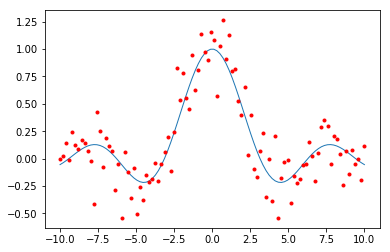

In [151]:
# Creates dataset

# 0: generates noise-free data/1: adds Gaussian noise to generated data/2: adds uniform noise to generated data
noise_option = 0

N = 100
global_sigma = 0.2

X = np.linspace(-10,10,N)
T = np.sin(abs(X))/abs(X)

if (noise_option == 1):
    t = T + np.random.normal(0, global_sigma, N)
elif (noise_option == 2):
    t = T + np.random.uniform(-global_sigma, global_sigma, N)
else:
    t = T
    
plt.plot(X,T,linewidth=1)
plt.plot(X,t,'r.')
plt.show()

In [152]:
# Creates kernel function

def linear_spline_kernel(x,y):
    min_value = min(x,y)
    return 1 + x*y + x*y*min_value - 0.5*(x+y)*pow(min_value,2) + (1./3)*pow(min_value,3)


In [153]:
# Computes re-estimation of hyperparameters alpha AND sigma (Beta version)

sigma = global_sigma

# The hyperparameters alpha_i are initially taken to be 1
alpha = np.ones(N+1)
A = np.diag(alpha)

# Keeps track of the indices of the relevant vectors
alpha_indices = np.linspace(0,N,N+1)
alpha_indices = alpha_indices.astype(int)

new_t = t

# Deals with the special case where w_0 is not relevant
not_removed_0 = 1

# Creates the design matrix Phi
Phi = np.ones((N,N+1))

# Note: this assumes that the kernel function is symmetric  
for i in range(N):
    
    for j in range(i+1):
        
        Phi[i][j+1] = linear_spline_kernel(X[i],X[j])
        Phi[j][i+1] = Phi[i][j+1]
        
new_Phi = Phi


# Main loop for the re-estimation of alpha
for i in range(30000):
    
    k = len(alpha_indices)
    small_Sigma = np.linalg.inv((1./pow(sigma,2))*np.dot(np.transpose(new_Phi),new_Phi) + A)
    
    B = np.zeros((k,N+1))
    B[:,alpha_indices] = small_Sigma
    
    Sigma = np.zeros((N+1,N+1))
    Sigma[alpha_indices,:] = B
    
    mu = (1./pow(sigma,2))*np.dot(Sigma,np.dot(np.transpose(Phi),t))
    
    gamma = 1 - alpha*np.diag(small_Sigma)
    alpha = gamma/pow(mu[alpha_indices],2)
    
    if (noise_option != 0):
        sigma = np.sqrt(pow(np.linalg.norm(t - np.dot(Phi,mu),2),2)/(N-sum(gamma)))
        
    # Prunes basis functions for which alpha_i tends to infinity
    prune = np.where(gamma < 2.22e-16)[0]
    
    # Keep tracks of the indices that are removed
    alpha_indices = np.delete(alpha_indices,prune)
    
    # There might be a problem with having to remove hyperparameter of index 0
    if ((0 in prune) & (not_removed_0)):
        
        prune = np.delete(prune,0)
        not_removed_0 = 0
        
        alpha = np.delete(alpha,0)
        new_Phi = np.delete(new_Phi,0,1)
        
    if (len(prune) > 0):
        
        alpha = np.delete(alpha,prune)

        # Checks if hyperparameter of index 0 has been removed
        if (not_removed_0):
            #new_Phi = np.delete(new_Phi,prune-1,0)
            new_Phi = np.delete(new_Phi,prune,1)
            new_t = np.delete(new_t,prune-1)
        else:
            #new_Phi = np.delete(new_Phi,prune,0)
            new_Phi = np.delete(new_Phi,prune,1)
            new_t = np.delete(new_t,prune)
    
    A = np.diag(alpha)
    
print(alpha_indices)
print(sigma)

[  0  17  30  55  64  84  85 100]
0.189582001937


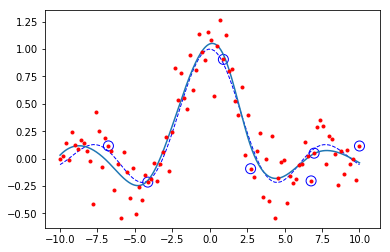

In [154]:
# Makes prediction for new points

X_test = np.linspace(-10,10,10*N)
Y_test = np.zeros(10*N)

# Particular case where index 0 is significant
if (alpha_indices[0] == 0):
    
    relevant_0 = True
    alpha_indices = np.delete(alpha_indices,0)
    relevance_vectors = X[alpha_indices-1]
    
else:
    
    relevant_0 = False
    relevance_vectors = X[alpha_indices-1]

for i in range(10*N):
    
    result = 0
    
    if (relevant_0):
        result += mu[0]
    
    for j in range(len(alpha_indices)):
        
        result += mu[alpha_indices[j]]*linear_spline_kernel(X_test[i],relevance_vectors[j])
        
    Y_test[i] = result

# Plots the estimator function and circles the relevant vectors
plt.plot(X, T, 'b--', linewidth=1)
plt.plot(X_test, Y_test)
plt.plot(X, t, 'r.')
plt.scatter(relevance_vectors, t[alpha_indices-1], s=100, facecolors='none', edgecolors='b') 
plt.show()


In [155]:
# Computes the errors of the estimator compared to the sinc function

# Maximum distance between estimator and function
T_test = np.sin(abs(X_test))/abs(X_test)
error_test = abs(T_test-Y_test)

print(max(error_test))

# Root mean square deviation

print(np.sqrt(sum(error_test*error_test)/(10*N)))


0.105782054196
0.0523099989519
